### 1. Setup

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import normaltest, mannwhitneyu, kruskal
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.stats.proportion as smp
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression
from scipy.stats import chi2_contingency
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.model_selection import GridSearchCV

### 2. Data Collection

In [4]:
CSV_PATH_CANDIDATES = [
    '/Users/rohilzalke/Desktop/DataSet/creditcard.csv'  
]

csv_path = None
for p in CSV_PATH_CANDIDATES:
    if os.path.exists(p):
        csv_path = p
        break

if csv_path is None:
    raise FileNotFoundError("Could not find 'creditcard.csv'. Place it in the notebook folder or update CSV_PATH_CANDIDATES.")

df = pd.read_csv(csv_path)
df.tail()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


### 3. Data Initial Checks

In [6]:
print("Shape:", df.shape)
print("\nColumn Info:")
print(df.info())
print("\nMissing values per columns:")
print(df.isnull().sum())
print("\nBasics Statisitcs:")
print(df.describe())
print("\n Class Distribution: ")
print(df['Class'].value_counts(normalize='True'))
print("\n This is a highly inbalanced dataset")
print("\n Check Dublicates: ")
print(df.duplicated().any())
df = df.drop_duplicates()
print("\n Dublicates are removed by df = df.drop_duplicates()")

Shape: (284807, 31)

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807

### 3. Exploratory Data Analysis (EDA)

##### i. Distribution of Amount

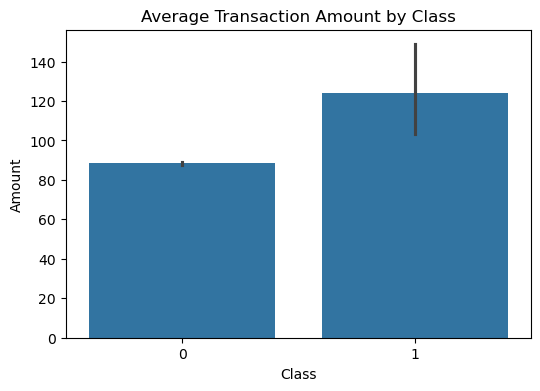

In [9]:
plt.figure(figsize=(6, 4))
sns.barplot(x='Class', y='Amount', data=df, estimator=np.mean)  # Default is mean, but explicit is good
plt.title("Average Transaction Amount by Class")
plt.show()

##### ii. Fraud Count

<Axes: xlabel='Class', ylabel='count'>

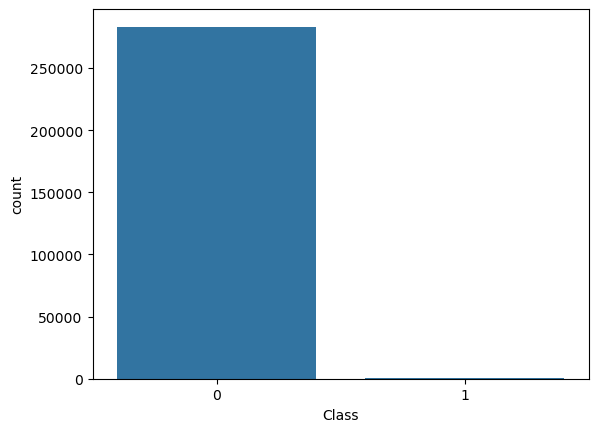

In [11]:
sns.countplot(x='Class', data=df)

##### iii. Correlation heatmap

<Axes: >

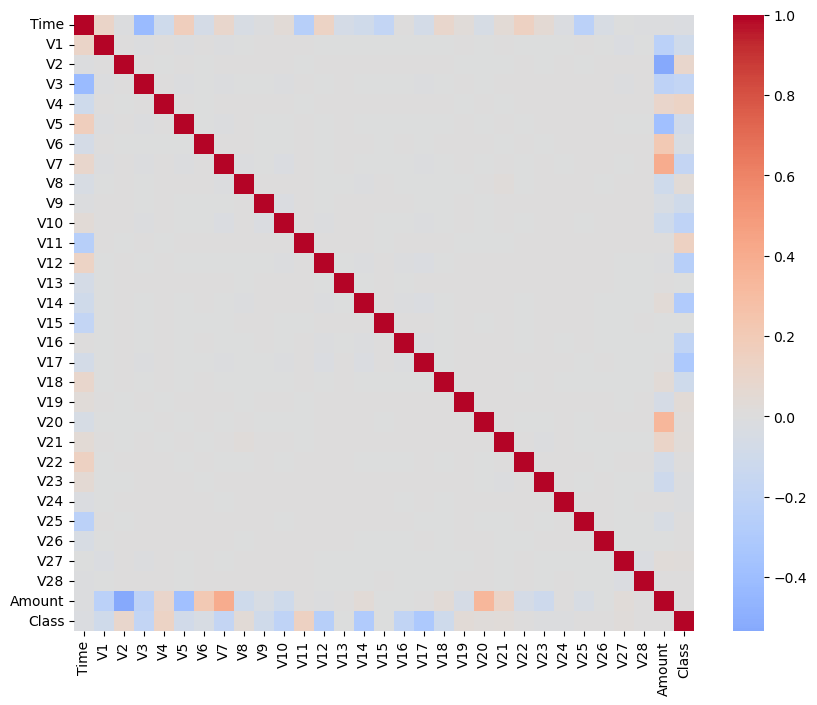

In [13]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap='coolwarm', center=0)

### 4. Statistics

##### i. Confidence Interval

In [16]:
df_new = df.copy()
X = df_new['Class'].value_counts()[1] #Frauds
n = df_new['Class'].value_counts()[0] + df_new['Class'].value_counts()[1] #Total transactions

ci_low, ci_high = smp.proportion_confint(X, n, alpha=0.05, method='normal')

# Convert to per 1,000 transactions
rate_low = ci_low * 1000
rate_high = ci_high * 1000
rate_est = (X/n) * 1000

print(f"Estimated fraud rate: {rate_est:.2f} per 1000 transactions")
print(f"95% CI: ({rate_low:.2f}, {rate_high:.2f}) per 1000 transactions")

Estimated fraud rate: 1.67 per 1000 transactions
95% CI: (1.52, 1.82) per 1000 transactions


##### ii. Feature Scaling

In [18]:
cols_to_scale = df.columns.difference(['Class'])
scaler = StandardScaler()
df_new[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

##### iii. Multivariate Checks using PCA (Principal Component Analysis)

In [20]:
pca = PCA()
pca.fit(df_new[cols_to_scale])

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance)

# Cumulative variance
cum_var = explained_variance.cumsum()
print("\n Cumulative variance:", cum_var)

Explained variance ratio: [0.0655915  0.05634035 0.0341207  0.03401796 0.03390283 0.03385678
 0.03372041 0.03366688 0.03363185 0.03361129 0.0336046  0.03356929
 0.03352902 0.03348723 0.03343523 0.03342327 0.03341597 0.03338659
 0.0333493  0.03333439 0.0333295  0.0332713  0.03321997 0.03320883
 0.03268492 0.03246466 0.03196936 0.03092892 0.01053669 0.00139041]

 Cumulative variance: [0.0655915  0.12193185 0.15605255 0.19007051 0.22397334 0.25783012
 0.29155053 0.32521741 0.35884926 0.39246055 0.42606514 0.45963443
 0.49316345 0.52665068 0.56008591 0.59350919 0.62692515 0.66031174
 0.69366104 0.72699543 0.76032494 0.79359624 0.82681621 0.86002504
 0.89270996 0.92517462 0.95714398 0.9880729  0.99860959 1.        ]


###### Explained variance ratio: No single PC dominates (like 50%+), meaning your dataset’s variance is spread out across many directions (complex structure).

###### Cumulative variance: We can still reduce from 30 → 20 PCs with ~73% variance preserved, which helps with noise reduction and speed.

##### iv. Q-Q Plot (Quantile-Quantile plot)- If points lie on the straight diagonal line → distribution is normal.

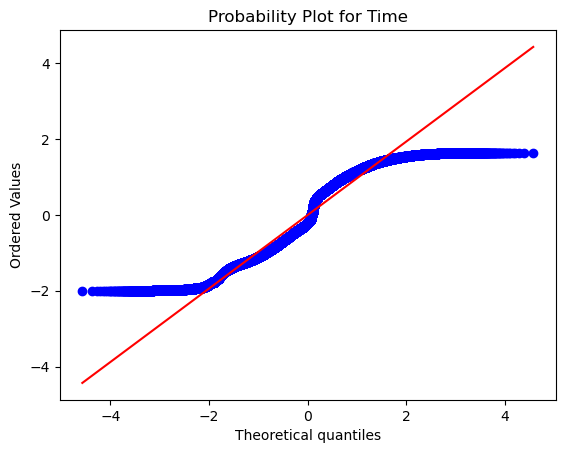

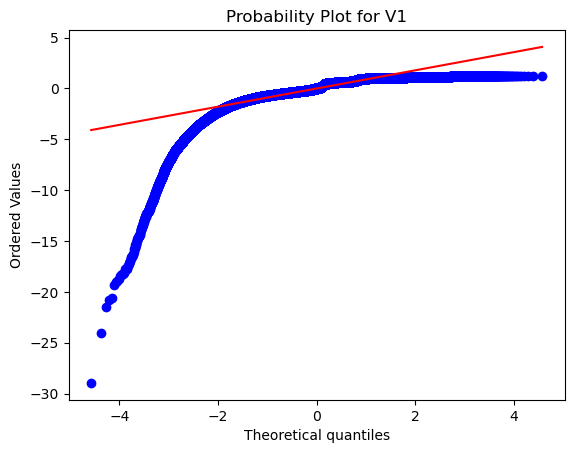

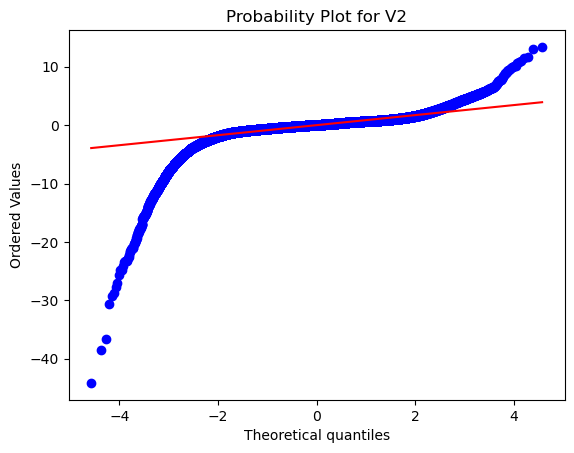

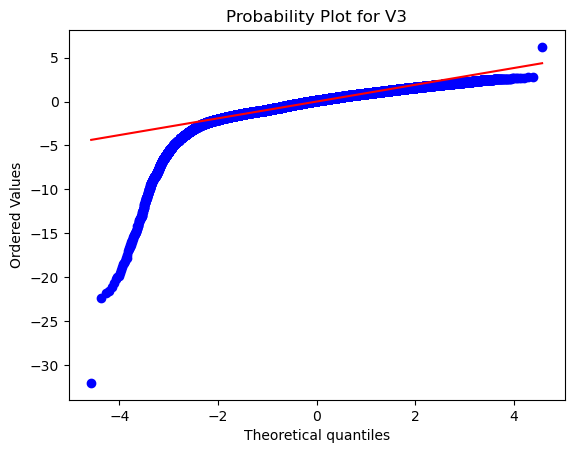

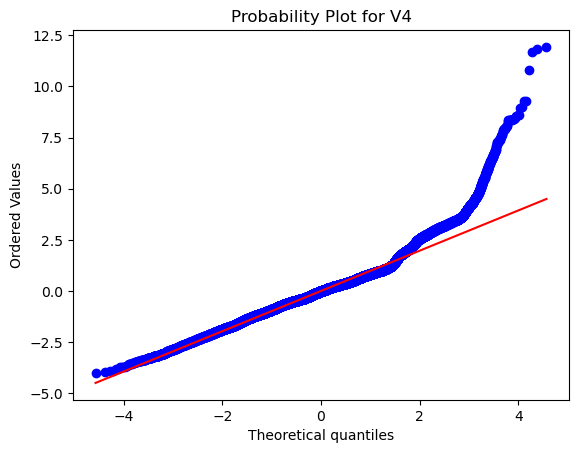

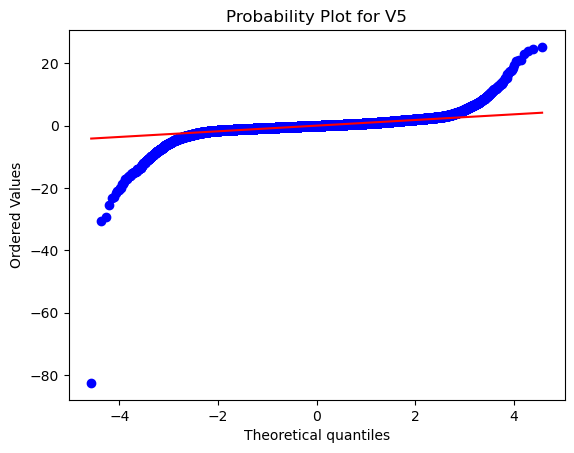

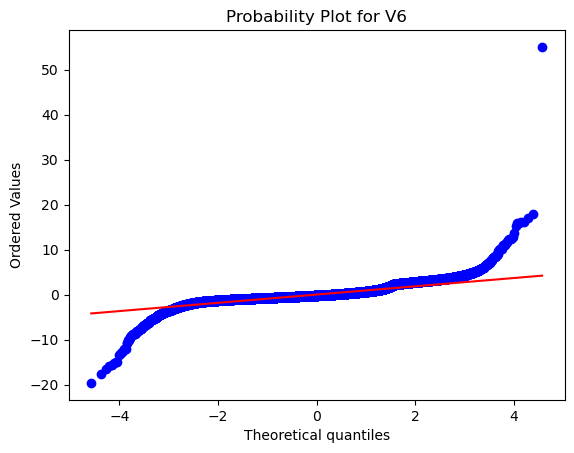

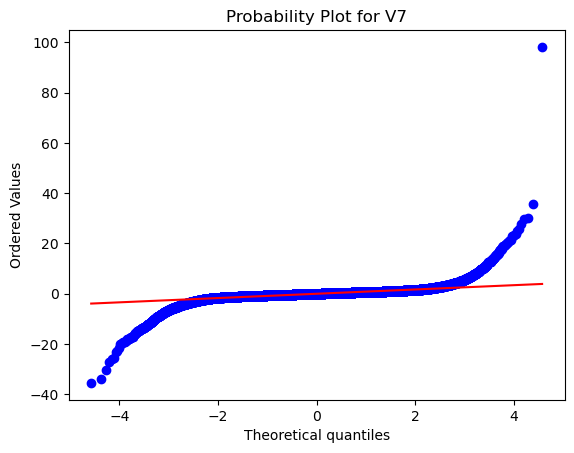

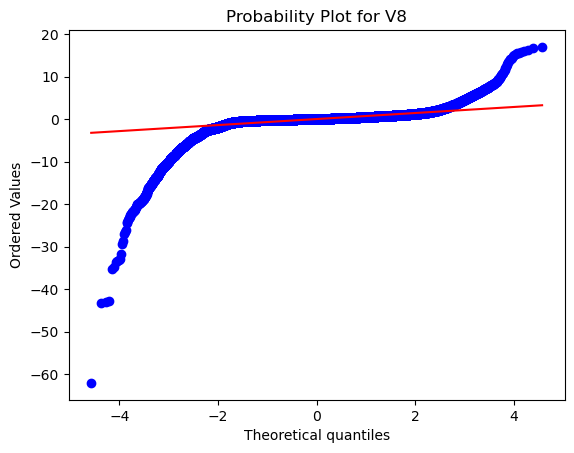

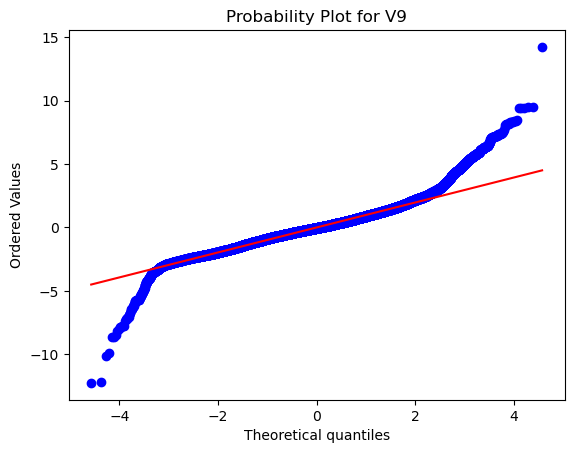

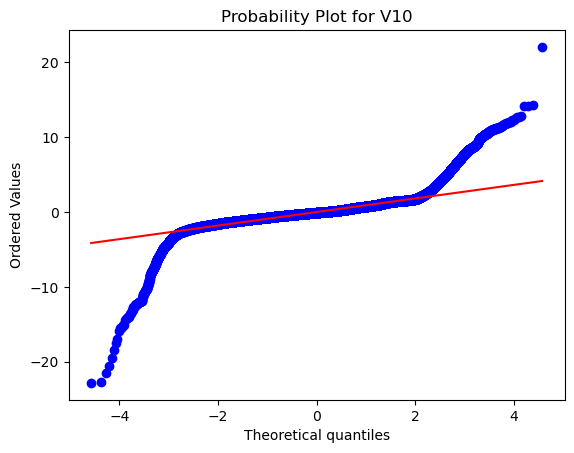

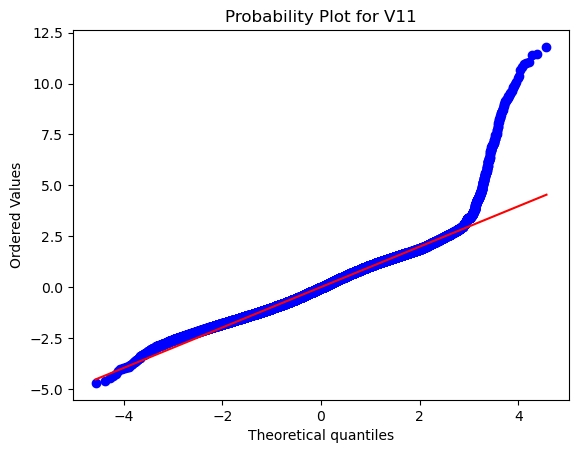

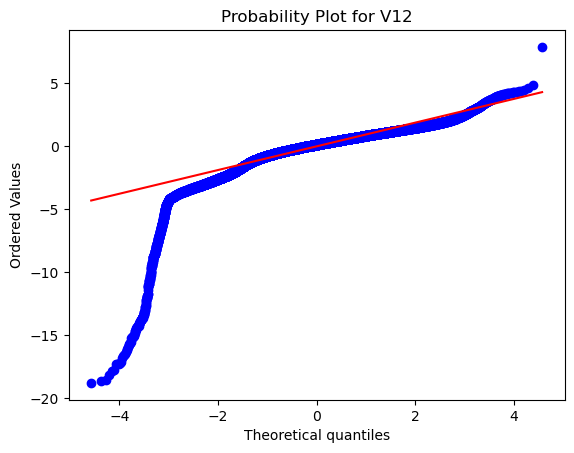

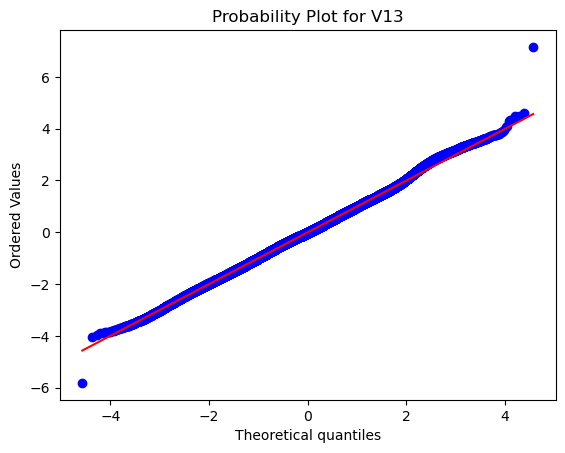

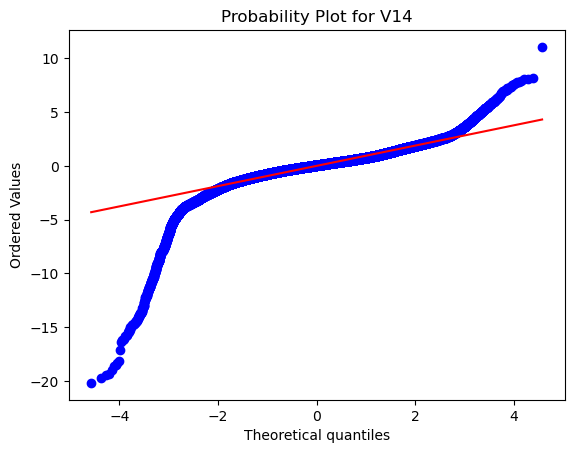

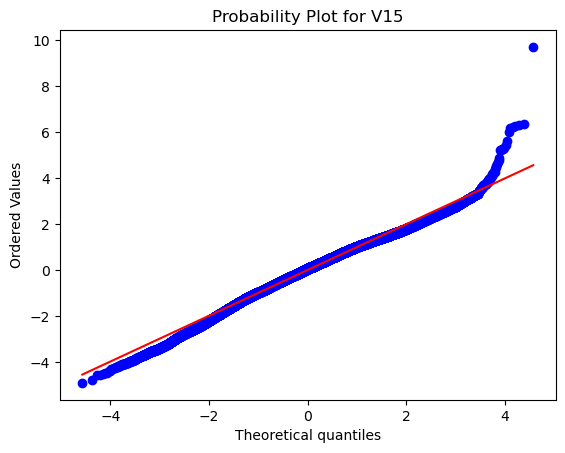

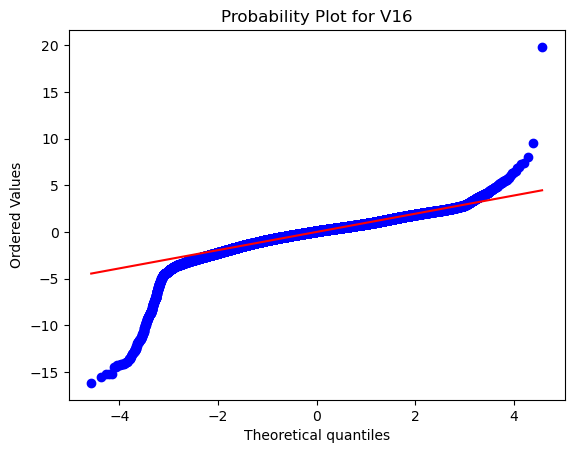

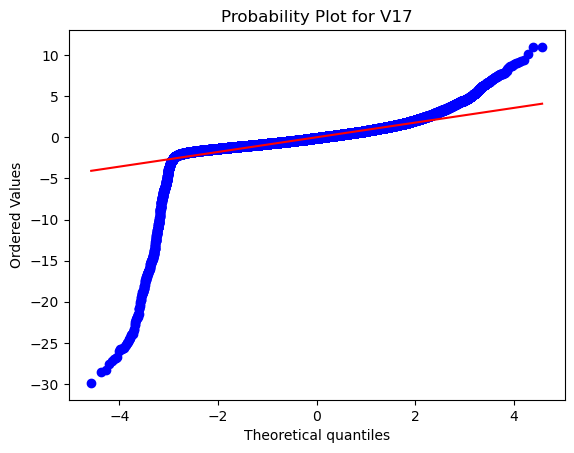

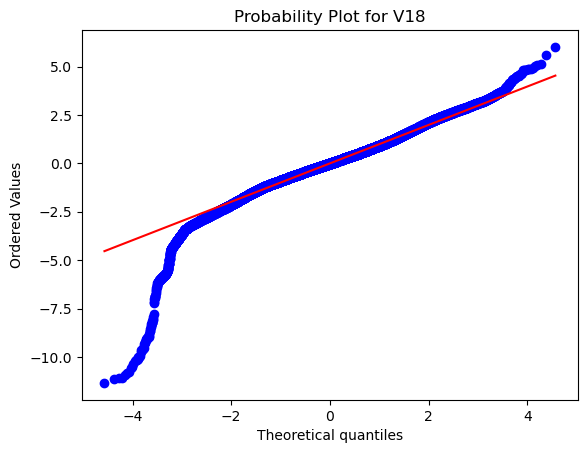

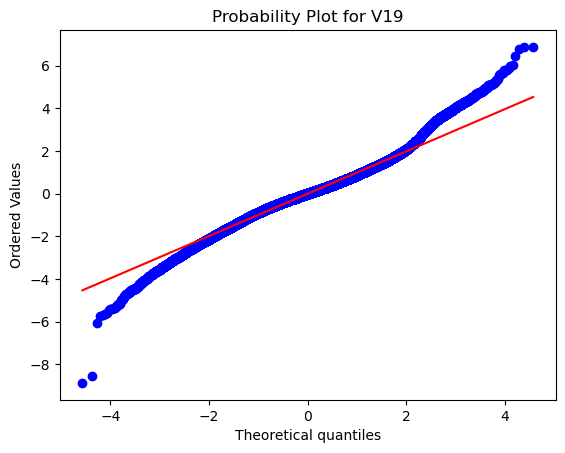

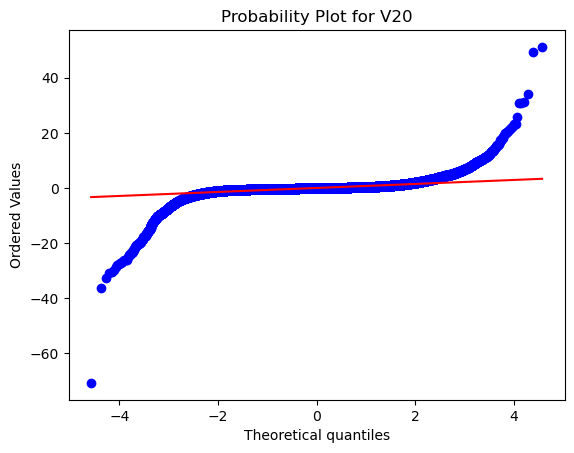

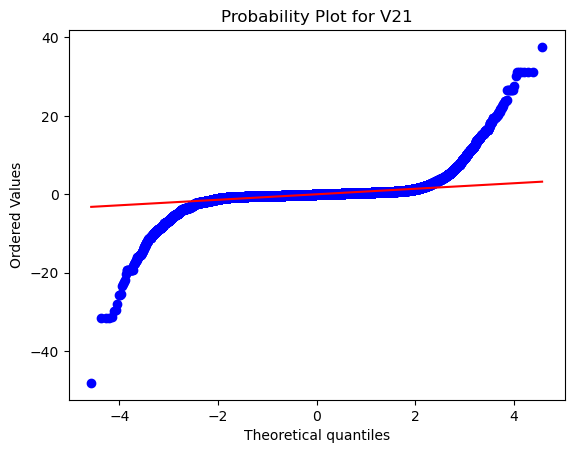

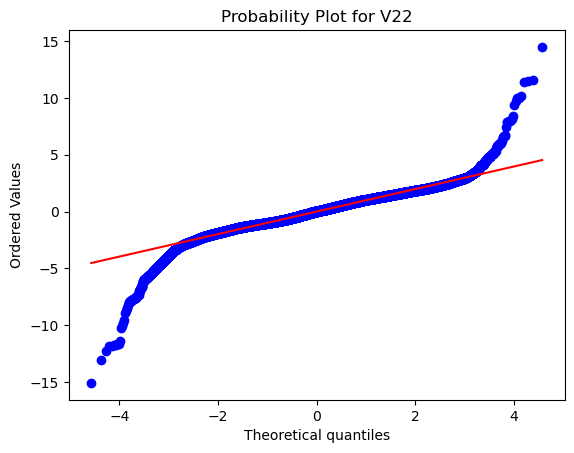

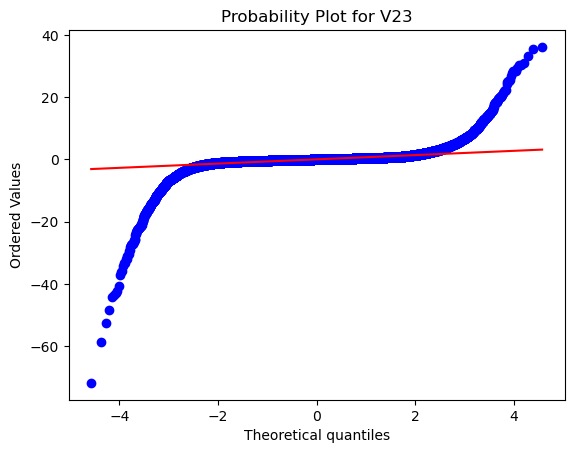

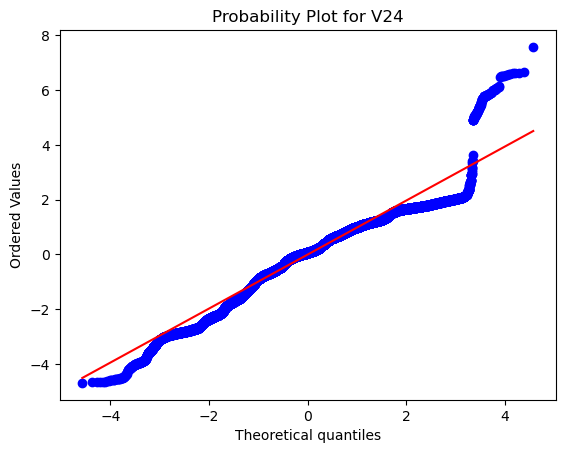

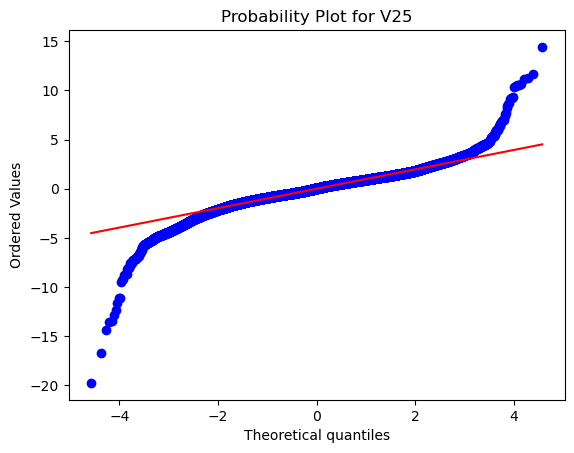

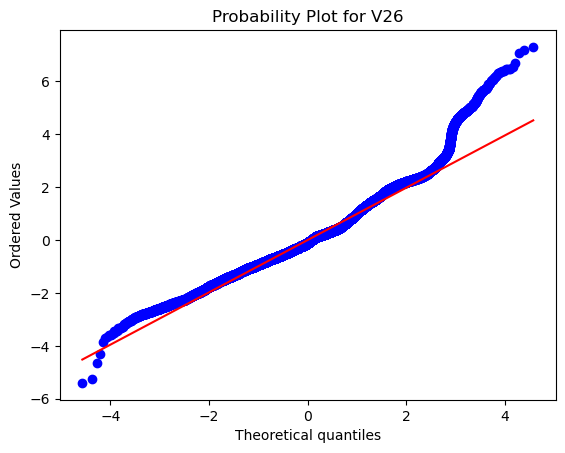

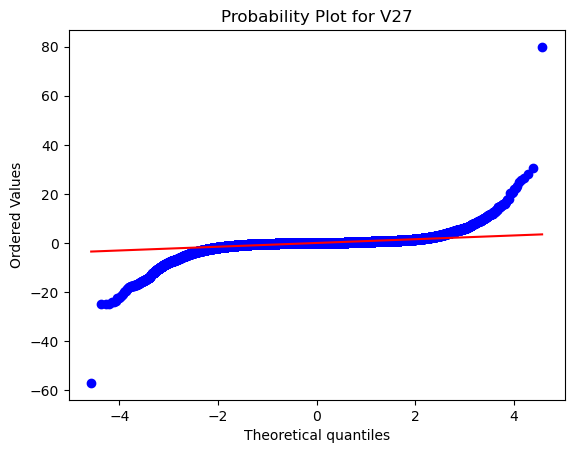

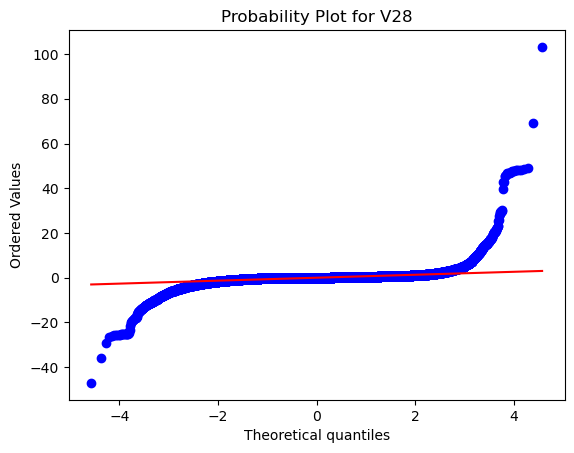

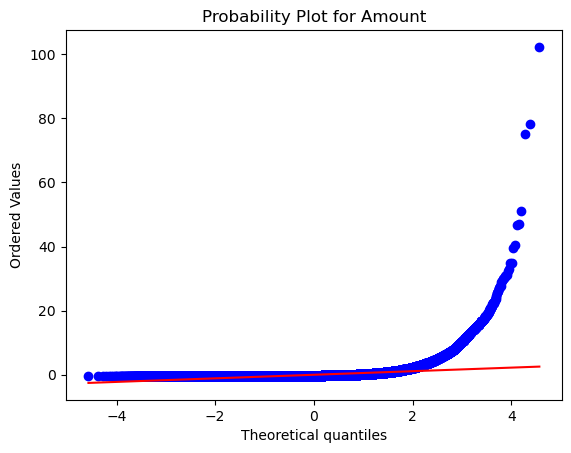

In [23]:
columns = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
           'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
           'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

for col in columns:
    plt.figure()
    stats.probplot(df_new[col], dist="norm", plot=plt)
    plt.title(f"Probability Plot for {col}") 
    plt.show()

In [24]:
columns = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
           'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
           'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

for col in columns:
    statss, p = normaltest(df_new[col])
    print(f"Statistics for {col} =%.3f, p for {col} =%.3f" % (statss, p))



Statistics for Time =930690.905, p for Time =0.000
Statistics for V1 =221154.544, p for V1 =0.000
Statistics for V2 =298933.403, p for V2 =0.000
Statistics for V3 =166048.418, p for V3 =0.000
Statistics for V4 =35205.116, p for V4 =0.000
Statistics for V5 =228353.028, p for V5 =0.000
Statistics for V6 =165132.189, p for V6 =0.000
Statistics for V7 =260682.668, p for V7 =0.000
Statistics for V8 =412948.310, p for V8 =0.000
Statistics for V9 =35200.282, p for V9 =0.000
Statistics for V10 =126458.362, p for V10 =0.000
Statistics for V11 =14994.531, p for V11 =0.000
Statistics for V12 =160201.757, p for V12 =0.000
Statistics for V13 =572.452, p for V13 =0.000
Statistics for V14 =152531.291, p for V14 =0.000
Statistics for V15 =5078.803, p for V15 =0.000
Statistics for V16 =84936.975, p for V16 =0.000
Statistics for V17 =263346.385, p for V17 =0.000
Statistics for V18 =19559.187, p for V18 =0.000
Statistics for V19 =11622.352, p for V19 =0.000
Statistics for V20 =216182.879, p for V20 =0.00

##### None of the features follow a normal distribution. Your dataset is highly non-Gaussian. This means we cannot use Parametric test, we need to use Non-Parametric test.

##### iii. Mann–Whitney U Test - Non-parametric statistical test used to compare two independent groups when the assumption of normality may not hold.

In [27]:
results = []

for col in df_new.columns:
    if col!= 'Class':
        Fraud = df_new[df_new['Class']==1][col]
        Not_fraud = df_new[df_new['Class']==0][col]

        stat, p = mannwhitneyu(Fraud, Not_fraud, alternative = 'two-sided')
        results.append(
            {
                'Feature': col,
                'Stattistics': stat,
                'P-value': p,
                'Significance': 'Yes' if p < 0.05 else 'No'
                
            }
        )

result_df = pd.DataFrame(results)
result_df = result_df.sort_values('P-value')

print(result_df)

   Feature  Stattistics        P-value Significance
14     V14    7082225.0  2.304859e-248          Yes
4       V4  125438246.0  1.599221e-236          Yes
12     V12    8781437.0  1.358344e-234          Yes
11     V11  122566787.0  4.678414e-214          Yes
10     V10   11980128.0  9.598036e-210          Yes
3       V3   12240264.0  8.738656e-208          Yes
2       V2  113855524.0  8.274562e-153          Yes
16     V16   21244264.0  1.110506e-145          Yes
9       V9   21264298.0  1.483634e-145          Yes
7       V7   22826763.0  6.513087e-136          Yes
17     V17   26732456.0  2.854261e-113          Yes
1       V1   28197486.0  2.570801e-105          Yes
6       V6   30983681.0   5.344062e-91          Yes
21     V21   99578153.0   6.872463e-75          Yes
18     V18   35744597.0   5.452518e-69          Yes
27     V27   94018959.0   4.334045e-52          Yes
5       V5   40179560.0   2.830042e-51          Yes
8       V8   88742548.0   2.368820e-34          Yes
20     V20  

In [28]:
fraud_no = df_new[df_new['Class']==0]['Amount']
fraud_yes = df_new[df_new['Class']==1]['Amount']
stat, p = kruskal(fraud_no, fraud_yes)

print("Stats: ", stat)
print("\nP-value: ", p)

Stats:  17.627969747939886

P-value:  2.6860869063774348e-05


### 5. Feature Engineering

In [30]:
df_n = df_new.copy()
df_n['Amount_bin'] = pd.qcut(df_n['Amount'], 4, labels=False)

In [31]:
table = pd.crosstab(df_n['Amount_bin'], df_n['Class'])
chi2, p, dof, expected = chi2_contingency(table)
print("Chi-square test statistic:", chi2)
print("p-value:", p)

Chi-square test statistic: 185.42101815169715
p-value: 5.9522420548649166e-40


##### This means your feature ['Amount_bin'] and the target feature ['Class'] have some association. Now aplying Cramer’s V to see how much strong association do we have

In [33]:
cramer_v = np.sqrt(chi2 / (n * (min(table.shape) - 1)))
print("Cramer's V:", cramer_v)

Cramer's V: 0.025564064995347708


###### Cramer's V: 0.025564064995347708, it means that there is a negligible association. 

### 6. Model Building & Prediction

##### SMOTE (Synthetic Minority Over-sampling Technique)is a way to fix imbalanced data. If one class has very few samples, it makes new, similar samples (not just copies) so both classes have nearly equal data.

In [37]:
X = df_new[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']]
y = df_new['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

smote = SMOTE(random_state=42)
X_train_n, y_train_n = smote.fit_resample(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


### i. Experimenting with RBF Kernel SVM (Computationally Intensive)

In [39]:
svm_comp_ext = SVC(kernel='rbf', C=1, gamma='scale', probability=True, random_state=42)
svm_comp_ext.fit(X_train_n, y_train_n)

y_pred_comp_ext = svm_comp_ext.predict(X_test)
print("Classification Report for RBF Kernel SVM:")
print(classification_report(y_test, y_pred_comp_ext))

print("\n Confusion Matrix for RBF Kernel SVM: ")
confusion_matrix(y_test, y_pred_comp_ext)

Classification Report for RBF Kernel SVM:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56651
           1       0.08      0.83      0.15        95

    accuracy                           0.98     56746
   macro avg       0.54      0.91      0.57     56746
weighted avg       1.00      0.98      0.99     56746


 Confusion Matrix for RBF Kernel SVM: 


array([[55763,   888],
       [   16,    79]])

##### Classification Report for RBF Kernel SVM
##### Class 0 (Not Fraud)
###### Precision = 1.00 → Almost all predicted "not fraud" are truly "not fraud".
###### Recall = 0.98 → The model catches 98% of the "not fraud" cases.
###### F1-score = 0.99 → Excellent balance between precision and recall.
###### The model is extremely good at detecting "not fraud" cases.
##### Class 1 (Fraud)
###### Precision = 0.08 → Of all the cases predicted as "fraud", only 8% were truly fraud. (High false positives.)
###### Recall = 0.83 → The model captures 83% of actual frauds (good sensitivity).
###### F1-score = 0.15 → Very low, because precision is very poor.
###### The model can find most frauds, but it also wrongly flags many normal transactions as fraud.

In [41]:
#####                Predicted 0    Predicted 1
##### Actual 0            TN           FP
##### Actual 1            FN           TP

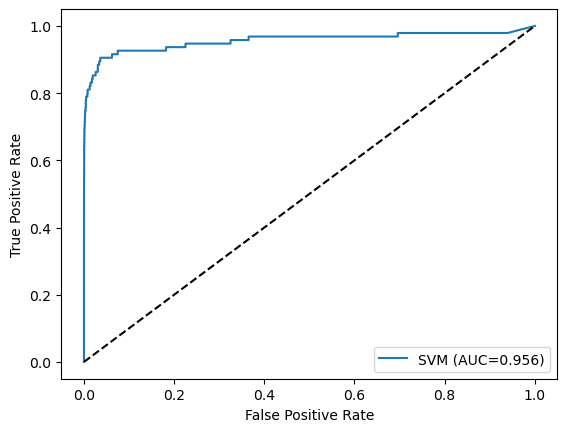

In [42]:
y_prod_comp_ext = svm_comp_ext.predict_proba(X_test)[:,1]
fpr, tpr,_ = roc_curve(y_test, y_prod_comp_ext)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"SVM (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

### ii. Efficient LinearSVC with Calibration (Fast & Scalable SVM for Large Datasets)

In [44]:
svm_clf = LinearSVC(random_state=42, max_iter=5000, class_weight = 'balanced')
calibrated_svm_fast = CalibratedClassifierCV(estimator=svm_clf, cv=3)
calibrated_svm_fast.fit(X_train_n, y_train_n)
y_pred_fast = calibrated_svm_fast.predict(X_test)

print("\n Classification Report for Effecient LinearSVC with Calibration:")
print(classification_report(y_test, y_pred_fast))

print("\n Confusion Matrix for Effecient LinearSVC with Calibration: ")
confusion_matrix(y_test, y_pred_fast)


 Classification Report for Effecient LinearSVC with Calibration:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56651
           1       0.06      0.87      0.10        95

    accuracy                           0.97     56746
   macro avg       0.53      0.92      0.55     56746
weighted avg       1.00      0.97      0.99     56746


 Confusion Matrix for Effecient LinearSVC with Calibration: 


array([[55228,  1423],
       [   12,    83]])

In [45]:
#####                Predicted 0    Predicted 1
##### Actual 0            TN           FP
##### Actual 1            FN           TP

##### Classification Report for Effecient LinearSVC with Calibration
##### Class 0 (Not Fraud)
###### Precision = 1.00 → Almost every "not fraud" predicted is truly not fraud.
###### Recall = 0.97 → Model catches 97% of not frauds.
###### F1-score = 0.99 → Excellent performance.

##### Class 1 (Fraud)
###### Precision = 0.06 → Of all cases flagged as fraud, only 6% are really fraud (very poor).
###### Recall = 0.87 → Model detects 87% of actual frauds (high recall).
###### F1-score = 0.10 → Still very weak because precision is terrible.
###### Catches most frauds, but also wrongly calls many normal transactions "fraud".

##### Confusion Matrix for Effecient LinearSVC with Calibration:
###### TN (True Negative, 55228) → Correctly predicted Not Fraud.
###### FP (False Positive, 1423) → Predicted Fraud, but it was Not Fraud.
###### FN (False Negative, 12) → Predicted Not Fraud, but it was Fraud (missed frauds).
###### TP (True Positive, 83) → Correctly predicted Fraud.

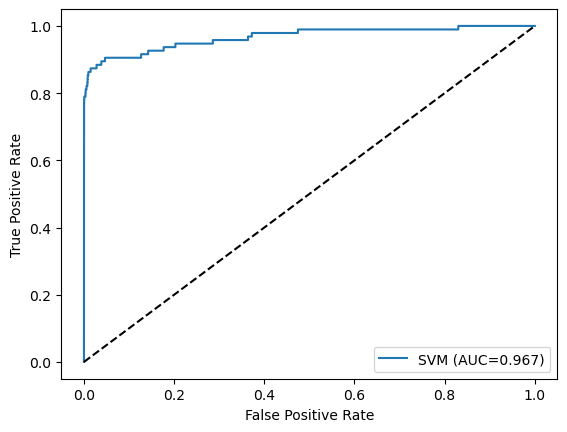

In [48]:
y_prod_fast = calibrated_svm_fast.predict_proba(X_test)[:,1]
fpr, tpr,_ = roc_curve(y_test, y_prod_fast)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"SVM (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

#### AUC = 0.97 → there’s a 97% chance that the model gives a higher score to a fraud case than to a non-fraud case.

### 7. Model for Comparision 

In [51]:
models = {
    "Logistic Regreesion": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "K-NN": KNeighborsClassifier()
}

for name, model in models.items():
    model.fit(X_train_n, y_train_n)
    pred_new = model.predict(X_test)
    print(f"\n {name}")
    print(classification_report(y_test, pred_new))


 Logistic Regreesion
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56651
           1       0.06      0.87      0.10        95

    accuracy                           0.97     56746
   macro avg       0.53      0.92      0.55     56746
weighted avg       1.00      0.97      0.99     56746


 Decision Tree
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.35      0.67      0.46        95

    accuracy                           1.00     56746
   macro avg       0.67      0.84      0.73     56746
weighted avg       1.00      1.00      1.00     56746


 K-NN
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.42      0.81      0.55        95

    accuracy                           1.00     56746
   macro avg       0.71      0.90      0.77     56746
weighted avg       1.00      

In [52]:
log_reg = LogisticRegression(max_iter=1000).fit(X_train_n, y_train_n)
log_preds = log_reg.predict(X_test)

contingency = confusion_matrix(y_test, y_pred_fast) + confusion_matrix(y_test, log_preds)
result = mcnemar(contingency, exact=False, correction=True)
print("McNemar’s test p-value:", result.pvalue)

McNemar’s test p-value: 0.0


### 8. Hypertunnning

In [54]:
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge']
}
grid = GridSearchCV(LinearSVC(random_state=42, max_iter=5000, class_weight = 'balanced', dual=False), param_grid, cv=3, scoring='f1')
grid.fit(X_train_n, y_train_n)
print("Best Parameters :", grid.best_params_)
print("\n Best Score: ", grid.best_score_)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
18 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py", line 321, in fit
    self.coef_, self.i

Best Parameters : {'C': 10, 'loss': 'squared_hinge', 'penalty': 'l2'}

 Best Score:  0.9404626289164355
